Using random forest regressor instead of the linear regressor in ML3.3.8

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
def in_out(auxhist, wrfout): #outputs the required input and output data from the auxhist and wrfout files
    DS_a = xr.open_dataset(auxhist) #dataset of auxhist
    DS_w = xr.open_dataset(wrfout) #dataset of wrfout
    
    T = (DS_w.T.values + DS_w.T0) * ((DS_w.P.values + DS_w.PB.values)/DS_w.P0)**(DS_w.R_D/DS_w.CP)
    st = DS_w.TSK.values #surface temp
    d_c = DS_w.TAU_OD.values #dust optical depth
    em = DS_w.EMISS.values #emissivity
    p = DS_w.P.values + DS_w.PB.values #pressure
    uif = DS_a.UPIRFLUX.values[1:,:,:,:] 

    temp_uif = []
    for i in range(52):
        temp_uif.append(uif[:,i,:,:].reshape(-1))
    uif = np.array(temp_uif).T
    uif.shape


    sla = [] #special layer arrays that are the feature vectors in the linear regression model
    sla.append((em*st**4).reshape(-1)) #don't have overall opacity, will deal with this issue later
    for i in range(52): #using all the layers now
        sla.append((np.exp(-d_c[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52): #using all the layers now
        sla.append((np.exp(-p[:,i,:,:])*T[:,i,:,:]**4).reshape(-1))
    for i in range(52):
        sla.append(p[:,i,:,:].reshape(-1)) #what if we just add pressures?
    sla = np.array(sla)
    sla = sla.T[2592:,:] #take transpose, remove first day of data (all lwr are 0 there)
    
    return sla, uif

In [4]:
sla_summer, uif_summer = in_out('af_summer', 'wf_summer')  #first snapshot of data (0002-00172), summer

In [5]:
sla_fall, uif_fall = in_out('af_fall', 'wf_fall') #(0002-00352), fall

In [6]:
sla_winter, uif_winter = in_out('af_winter', 'wf_winter') #(0002-00352), winter 

In [7]:
sla_spring, uif_spring = in_out('af_spring', 'wf_spring') #(0002-00652), spring 

In [8]:
sla_test_set, uif_test_set = in_out("af_test", "wf_test") #(0002-00472), testing on this as well to check if overfit

In [44]:
uif_train = np.concatenate((uif_summer, uif_fall, uif_winter, uif_spring), axis=0) #total uif for training

In [45]:
sla_train = np.concatenate((sla_summer, sla_fall, sla_winter, sla_spring), axis=0) #total sla for training

In [46]:
uif_train = uif_train[::100]
sla_train = sla_train[::100] #use every 1000th element from original training data

In [47]:
sla_train.shape

(22706, 157)

In [21]:
#from sklearn.model_selection import train_test_split
#sla_train, sla_test, uif_train, uif_test = train_test_split(sla_train, uif_train, test_size=0.99, random_state=42)

In [22]:
sla_summer.shape

(619488, 157)

# Predicting Summer:

In [48]:
from sklearn.ensemble import RandomForestRegressor
rfr1 = RandomForestRegressor()
rfr1.fit(sla_train,uif_train)
uif_lin = rfr1.predict(sla_summer)  
uif_out = uif_summer

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [49]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

2.809884778594962

In [50]:
np.min(uif_out)

17.541994

In [51]:
np.max(uif_out)

339.41235

In [52]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

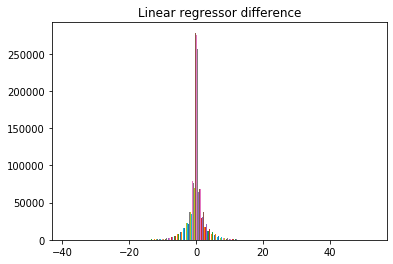

In [53]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [54]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [55]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

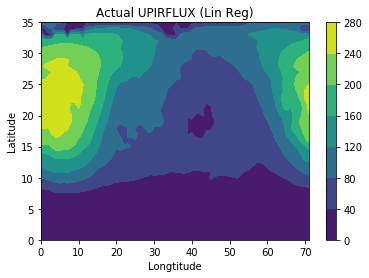

In [56]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

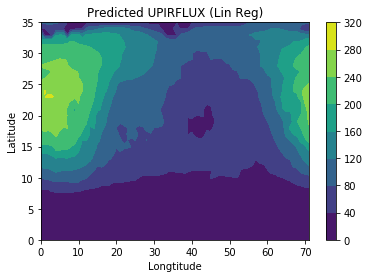

In [57]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

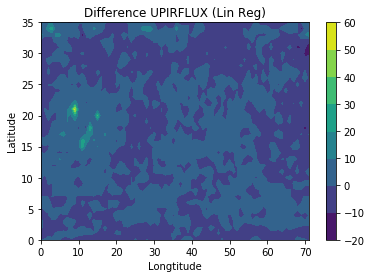

In [58]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

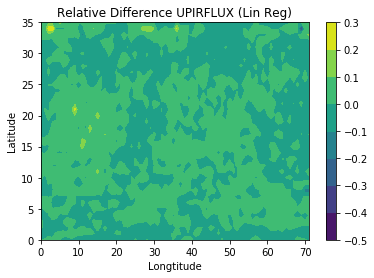

In [59]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [60]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [61]:
real_out.shape

(36, 72)

In [62]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [63]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.21953878, -0.00618611,  0.20428023, ...,  0.01462741,
         0.17543352, -0.0113045 ],
       [ 0.21953352, -0.00618597,  0.20426863, ...,  0.0146168 ,
         0.175431  , -0.01130198],
       [ 0.21952994, -0.00618558,  0.20426022, ...,  0.01460928,
         0.175429  , -0.0112999 ],
       ...,
       [ 0.76086375,  0.34610783,  0.61055862, ...,  0.43495104,
         0.63756235,  0.26795851],
       [ 0.75840156,  0.33555994,  0.60800984, ...,  0.43159647,
         0.63020997,  0.25727742],
       [ 0.74593372,  0.31857008,  0.59905425, ...,  0.42090132,
         0.61071783,  0.23938224]])

In [64]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.31759955, 0.31759144, 0.31758573, 0.31755486, 0.31744597,
       0.31729182, 0.31721164, 0.31697962, 0.3165678 , 0.31632568,
       0.31648828, 0.31666627, 0.31639817, 0.31566447, 0.3148144 ,
       0.31406327, 0.31315574, 0.31155238, 0.3094332 , 0.30729762,
       0.30559109, 0.30564361, 0.30908314, 0.31714208, 0.32960223,
       0.34624184, 0.36471213, 0.38217775, 0.40090984, 0.42271168,
       0.4460069 , 0.46522219, 0.48149314, 0.49792302, 0.52226527,
       0.57170307, 0.63658419, 0.69823662, 0.75094525, 0.77238555,
       0.79450862, 0.80743226, 0.81931176, 0.82978672, 0.8390501 ,
       0.84476345, 0.85052022, 0.85612681, 0.8603222 , 0.86083152,
       0.85157354, 0.82835611])

In [65]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.13473478, -0.13473765, -0.13473937, -0.13478717, -0.13483946,
       -0.1349273 , -0.13506986, -0.13506257, -0.1350592 , -0.13515   ,
       -0.13524937, -0.13520278, -0.13527361, -0.13581174, -0.13688614,
       -0.13816588, -0.13953323, -0.14117021, -0.14344273, -0.14657171,
       -0.14951636, -0.15063068, -0.14831313, -0.14115071, -0.12981039,
       -0.1155769 , -0.1011987 , -0.0900891 , -0.0816944 , -0.07271692,
       -0.06169653, -0.05093323, -0.04203881, -0.03215953, -0.0096238 ,
        0.03557007,  0.09150477,  0.14364286,  0.17555004,  0.18120798,
        0.18324933,  0.18324093,  0.18252075,  0.18101551,  0.17817452,
        0.17494682,  0.17011078,  0.16340138,  0.15481337,  0.14437435,
        0.12939488,  0.10669154])

In [66]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.10998541, 0.10998427, 0.10998336, 0.109997  , 0.10998781,
       0.10994017, 0.10996654, 0.10987523, 0.10970668, 0.10965947,
       0.10977089, 0.1098869 , 0.10990031, 0.10986495, 0.10988926,
       0.10999627, 0.1101009 , 0.11006523, 0.1099483 , 0.10993887,
       0.11000265, 0.1100544 , 0.11011873, 0.11016909, 0.11005007,
       0.10981524, 0.10993828, 0.11086568, 0.11270938, 0.11508303,
       0.11752133, 0.11924164, 0.12085144, 0.12237541, 0.12279528,
       0.12375305, 0.12536391, 0.12697268, 0.13163617, 0.13579513,
       0.14125836, 0.14468031, 0.14786521, 0.15090336, 0.154327  ,
       0.15731251, 0.16118345, 0.16578279, 0.17070388, 0.17516417,
       0.17733178, 0.17791699])

In [67]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.09162441, 0.0916182 , 0.09161381, 0.09157932, 0.09151637,
       0.09140298, 0.09128333, 0.09114971, 0.09099602, 0.09087818,
       0.09077579, 0.09062227, 0.09037843, 0.08992496, 0.08916743,
       0.08811314, 0.08678336, 0.08511796, 0.08311345, 0.08074124,
       0.07834035, 0.07724792, 0.07942968, 0.08656481, 0.09870801,
       0.11479834, 0.13187651, 0.14727566, 0.16228873, 0.17812568,
       0.19360349, 0.20587332, 0.21694828, 0.23183669, 0.26044014,
       0.31201747, 0.37271343, 0.42553972, 0.46260671, 0.47474947,
       0.48581622, 0.49164856, 0.49657874, 0.50065795, 0.50410295,
       0.50603544, 0.50728159, 0.50737708, 0.50615634, 0.50322105,
       0.49646728, 0.48183629])

In [68]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.23243392860237277


# Predicting Fall:

In [69]:
uif_lin = rfr1.predict(sla_fall) 
uif_out = uif_fall

In [70]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.7935732951628545

In [71]:
np.min(uif_out)

15.713927

In [72]:
np.max(uif_out)

484.24545

In [73]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

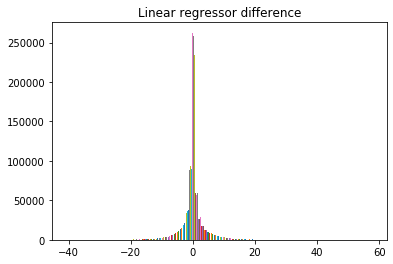

In [74]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [75]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [76]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

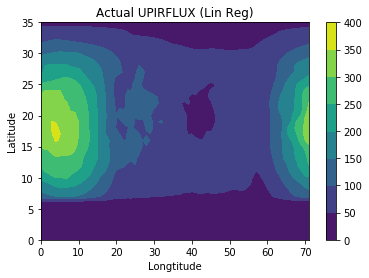

In [77]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

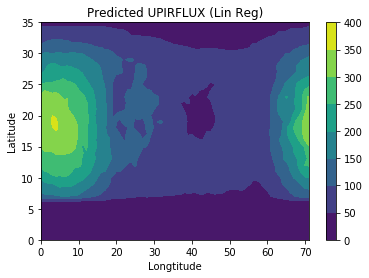

In [78]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

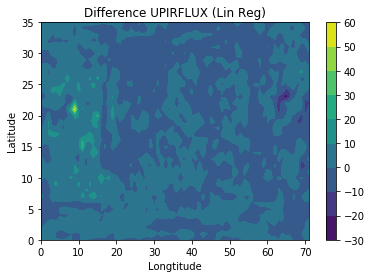

In [79]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

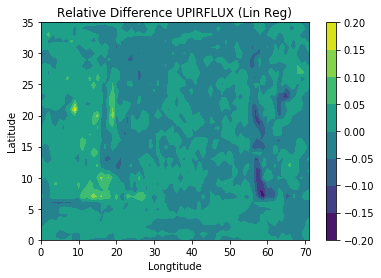

In [80]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [81]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [82]:
real_out.shape

(36, 72)

In [83]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [84]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[-0.04536928, -0.33776882,  0.24757317, ..., -0.21531029,
         0.04399571, -0.26476067],
       [-0.0453681 , -0.33776726,  0.24758531, ..., -0.21530783,
         0.04399862, -0.26474928],
       [-0.04536722, -0.33776599,  0.24759469, ..., -0.21530628,
         0.04400104, -0.26474098],
       ...,
       [-0.34405017, -0.74948024, -0.21647944, ..., -0.56839733,
        -0.19360247, -0.67097741],
       [-0.35197373, -0.7479129 , -0.20667759, ..., -0.53848911,
        -0.20173443, -0.67424485],
       [-0.33570437, -0.76041177, -0.17750348, ..., -0.49084594,
        -0.18987467, -0.69040501]])

In [85]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([ 0.40939981,  0.40940992,  0.40941712,  0.40954546,  0.40971355,
        0.40968618,  0.40981043,  0.41000343,  0.40984243,  0.40921243,
        0.40893998,  0.40873954,  0.40843363,  0.40810336,  0.40803732,
        0.40828247,  0.40869733,  0.40920314,  0.40949293,  0.40910227,
        0.40714021,  0.40274593,  0.39528735,  0.3837359 ,  0.36821076,
        0.34901545,  0.32649822,  0.29803453,  0.26562903,  0.23405733,
        0.20429407,  0.17374852,  0.14572221,  0.12428418,  0.11063054,
        0.09543326,  0.07166621,  0.03770337,  0.00352327, -0.00875646,
       -0.01842087, -0.02255119, -0.0254073 , -0.02685612, -0.02738348,
       -0.02764977, -0.02793913, -0.02860395, -0.0296689 , -0.02714625,
       -0.01505744,  0.01435752])

In [86]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.46507361, -0.46507273, -0.46507185, -0.46513592, -0.46518556,
       -0.46516667, -0.46513086, -0.46530348, -0.465598  , -0.4653115 ,
       -0.46483537, -0.46482032, -0.46537165, -0.4661167 , -0.4666721 ,
       -0.46690517, -0.46653617, -0.46528176, -0.46324202, -0.46083312,
       -0.46053748, -0.46294906, -0.46879729, -0.47919052, -0.49475784,
       -0.5158824 , -0.54130654, -0.57154543, -0.60558787, -0.64015375,
       -0.67306125, -0.70631987, -0.73813462, -0.7681312 , -0.80032534,
       -0.83268649, -0.85692512, -0.88124946, -0.90601977, -0.91726942,
       -0.92875107, -0.93554513, -0.94216373, -0.94785567, -0.95226836,
       -0.95372159, -0.95307712, -0.95026719, -0.94497426, -0.93738239,
       -0.93591008, -0.94004118])

In [87]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.26082717, 0.260831  , 0.26083379, 0.26089709, 0.26097948,
       0.26098367, 0.26097472, 0.26103115, 0.26103588, 0.26087243,
       0.26069757, 0.2604427 , 0.26029819, 0.26036621, 0.26060952,
       0.26080229, 0.26072717, 0.26034819, 0.25973163, 0.25893699,
       0.25808272, 0.25738145, 0.25687844, 0.2564879 , 0.25624741,
       0.25626768, 0.25631418, 0.25561546, 0.25439895, 0.2530979 ,
       0.25138598, 0.24939952, 0.24830546, 0.24802988, 0.2496508 ,
       0.25185539, 0.25006985, 0.24637831, 0.24544377, 0.24658224,
       0.24878798, 0.25063834, 0.25280665, 0.25507164, 0.25734514,
       0.2586194 , 0.25939705, 0.25931648, 0.25742006, 0.2536433 ,
       0.25204827, 0.25908149])

In [88]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([-0.08999485, -0.08999045, -0.08998707, -0.08996282, -0.08993785,
       -0.09002883, -0.09000444, -0.08987548, -0.08974284, -0.08966195,
       -0.0897142 , -0.09003159, -0.09033627, -0.09059198, -0.09086882,
       -0.09100736, -0.09065901, -0.08968515, -0.08839364, -0.08727198,
       -0.0874104 , -0.0899906 , -0.09588572, -0.10619738, -0.12094913,
       -0.14009585, -0.16263886, -0.18969529, -0.21983077, -0.24939889,
       -0.27607758, -0.30126939, -0.32451305, -0.34625568, -0.36751115,
       -0.38929684, -0.40795572, -0.42883608, -0.44999443, -0.45703645,
       -0.4632668 , -0.46685016, -0.47041854, -0.47389802, -0.47704632,
       -0.47854407, -0.47909274, -0.47823678, -0.47510507, -0.46910033,
       -0.46016231, -0.44016295])

In [89]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
-0.2430859594872194


# Predicting Winter:

In [91]:
uif_lin = rfr1.predict(sla_winter)  
uif_out = uif_winter

In [92]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

5.19520151259162

In [93]:
np.min(uif_out)

15.832658

In [94]:
np.max(uif_out)

485.98044

In [95]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

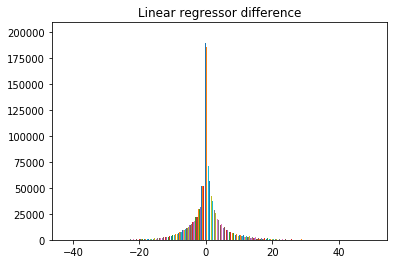

In [96]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [97]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [98]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

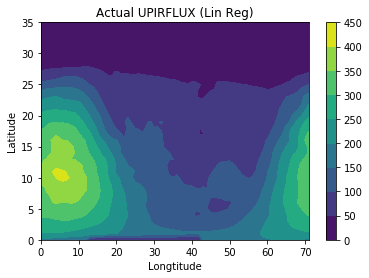

In [99]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

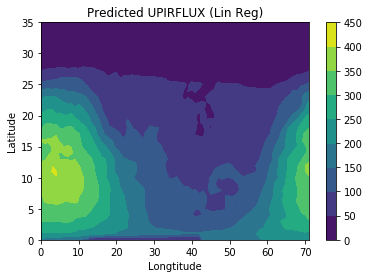

In [100]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

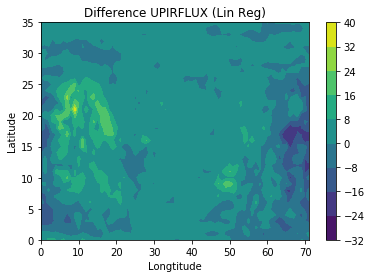

In [101]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

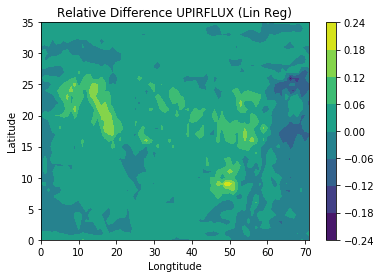

In [102]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [103]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [104]:
real_out.shape

(36, 72)

In [105]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [106]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[1.78171945, 2.2890187 , 1.85078884, ..., 1.09326136, 0.90588572,
        1.16172145],
       [1.78168818, 2.28899065, 1.85074598, ..., 1.0932446 , 0.90586417,
        1.16168284],
       [1.78166636, 2.28896974, 1.85071515, ..., 1.09323209, 0.90584784,
        1.16165373],
       ...,
       [2.90234995, 3.10573012, 2.55666923, ..., 1.73796488, 1.67451882,
        1.53374918],
       [2.86191063, 3.07480048, 2.52016217, ..., 1.73809193, 1.65333477,
        1.53142632],
       [2.81071485, 3.00430377, 2.48209279, ..., 1.74091944, 1.62741286,
        1.50022207]])

In [107]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([2.2890187 , 2.28899065, 2.28896974, 2.28889216, 2.28862912,
       2.28833083, 2.2872044 , 2.28538503, 2.28404887, 2.28377453,
       2.28473888, 2.28723902, 2.29197032, 2.29901984, 2.30663443,
       2.3124613 , 2.31714832, 2.32277349, 2.32870406, 2.33435726,
       2.3413673 , 2.35258587, 2.37183658, 2.40352784, 2.44796731,
       2.49968412, 2.55369689, 2.61149433, 2.67519471, 2.74447226,
       2.81903458, 2.89640258, 2.9734693 , 3.0485495 , 3.12286722,
       3.18378354, 3.20976427, 3.21597888, 3.21142665, 3.20123002,
       3.18372376, 3.17007056, 3.15472446, 3.13944256, 3.12777869,
       3.12359227, 3.1226034 , 3.12258781, 3.11809994, 3.10573012,
       3.07480048, 3.00430377])

In [108]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([0.90588572, 0.90586417, 0.90584784, 0.90558699, 0.90534107,
       0.9054334 , 0.90601235, 0.90650926, 0.90678844, 0.90682812,
       0.90672671, 0.90670395, 0.90734506, 0.90958357, 0.91313833,
       0.91614588, 0.91806664, 0.92019464, 0.92244679, 0.9237844 ,
       0.92750666, 0.94059926, 0.96398275, 0.99252414, 1.02131429,
       1.05132428, 1.08555332, 1.12651137, 1.17525731, 1.23317913,
       1.30112914, 1.37636583, 1.45636229, 1.50155029, 1.53249086,
       1.54025481, 1.52806407, 1.50564223, 1.4763919 , 1.45813251,
       1.43609205, 1.42136127, 1.40520467, 1.38809577, 1.37016533,
       1.35742537, 1.34275716, 1.32714012, 1.31302581, 1.30146083,
       1.28986396, 1.28253361])

In [109]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.27123565, 0.2712324 , 0.27123016, 0.27122888, 0.27120164,
       0.27112835, 0.27085808, 0.27044685, 0.27004769, 0.26984667,
       0.27012947, 0.27105205, 0.27248037, 0.27393192, 0.27477087,
       0.27486035, 0.27476964, 0.27481787, 0.27484752, 0.27510233,
       0.27596359, 0.2770984 , 0.27821487, 0.28005697, 0.28362411,
       0.28845424, 0.29302777, 0.29714061, 0.30153193, 0.30637969,
       0.31105668, 0.31468009, 0.31749553, 0.32078334, 0.3256296 ,
       0.33218222, 0.33986937, 0.34790175, 0.35340567, 0.35503245,
       0.35604176, 0.35622799, 0.35622346, 0.35613897, 0.35632205,
       0.3568425 , 0.35768097, 0.35810691, 0.35715782, 0.35468699,
       0.34936069, 0.33783478])

In [110]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([1.46760626, 1.46757479, 1.46755159, 1.46732111, 1.46695164,
       1.4665958 , 1.4664597 , 1.46628423, 1.46620436, 1.46637206,
       1.46689117, 1.46793268, 1.46975839, 1.47249086, 1.47614683,
       1.48040518, 1.48480892, 1.48937777, 1.49424475, 1.50028301,
       1.5093344 , 1.52312963, 1.54235083, 1.5679004 , 1.59969342,
       1.63737035, 1.6807592 , 1.73065825, 1.78716686, 1.85000343,
       1.91877699, 1.9920677 , 2.06766834, 2.14184869, 2.20283273,
       2.24231213, 2.26079161, 2.26730292, 2.26566699, 2.26076729,
       2.25204269, 2.24512367, 2.23678857, 2.22712883, 2.21704553,
       2.21072311, 2.20512199, 2.19927685, 2.1906543 , 2.17848729,
       2.15994732, 2.12981231])

In [111]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
1.8071503021711406


# Predicting Spring:

In [112]:
uif_lin = rfr1.predict(sla_spring)
uif_out = uif_spring

In [113]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

3.3106247313902037

In [114]:
np.min(uif_out)

15.936197

In [115]:
np.max(uif_out)

414.86307

In [116]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

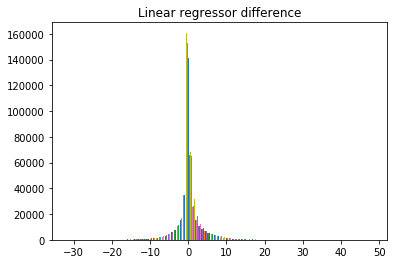

In [117]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [118]:
uif_out.reshape(-1,1).shape

(21430656, 1)

In [119]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

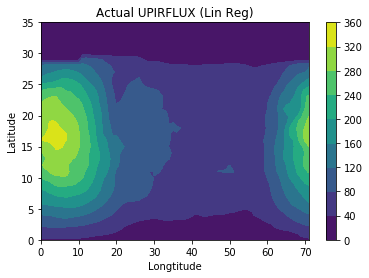

In [120]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

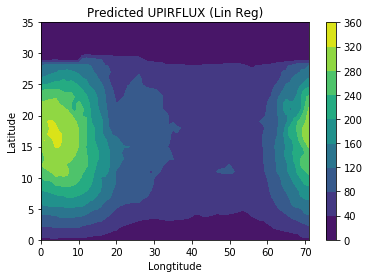

In [121]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

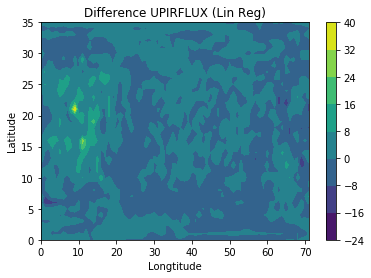

In [122]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

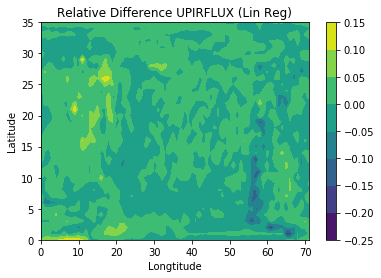

In [123]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [124]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [125]:
real_out.shape

(36, 72)

In [126]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [127]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[ 0.03257877, -0.26031636,  0.45913258, ...,  0.42687991,
         0.30294995,  0.10269083],
       [ 0.03258414, -0.26031618,  0.45913623, ...,  0.42687686,
         0.30295434,  0.10268712],
       [ 0.03258811, -0.26031596,  0.45913877, ...,  0.42687474,
         0.30295779,  0.10268439],
       ...,
       [ 0.09650108, -0.35890124,  0.20775835, ...,  0.66939413,
         0.53449299,  0.17159923],
       [ 0.08880553, -0.35913308,  0.22130955, ...,  0.68585708,
         0.51836428,  0.16688128],
       [ 0.08893007, -0.37655369,  0.24807122, ...,  0.70792748,
         0.51250497,  0.14427095]])

In [128]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([0.61776593, 0.61777255, 0.61777759, 0.61786898, 0.61803521,
       0.61813154, 0.61813423, 0.61795912, 0.61719658, 0.61654406,
       0.61616644, 0.61601098, 0.61599414, 0.61582038, 0.61536484,
       0.61464741, 0.61350455, 0.61193188, 0.61051379, 0.60990372,
       0.61043857, 0.61179274, 0.61248544, 0.61063714, 0.6056486 ,
       0.59802553, 0.58883857, 0.57895437, 0.57046854, 0.56430026,
       0.56021707, 0.55724713, 0.55608096, 0.5575747 , 0.56285706,
       0.56937095, 0.57920601, 0.61443012, 0.63403748, 0.6388566 ,
       0.64377431, 0.64651981, 0.65079594, 0.65489221, 0.65820761,
       0.66056392, 0.66283542, 0.66538754, 0.671968  , 0.68793132,
       0.71378304, 0.74707142])

In [129]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([-0.32512193, -0.32512267, -0.32512289, -0.32511492, -0.32510196,
       -0.32516253, -0.32504346, -0.3250686 , -0.32537111, -0.32607597,
       -0.3267602 , -0.32709186, -0.32728874, -0.32749573, -0.32765967,
       -0.32804231, -0.32894304, -0.33023666, -0.33118218, -0.33144644,
       -0.33142484, -0.33164734, -0.33284267, -0.33637126, -0.34243302,
       -0.3498759 , -0.35745016, -0.36466399, -0.37143667, -0.37855483,
       -0.38360716, -0.38355564, -0.37642538, -0.36598255, -0.36051309,
       -0.36333067, -0.37952404, -0.39874374, -0.413149  , -0.42097743,
       -0.42946735, -0.43421933, -0.43932537, -0.44493218, -0.45102127,
       -0.454841  , -0.45703573, -0.45725878, -0.45457723, -0.44863869,
       -0.44595325, -0.46304587])

In [130]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.24990825, 0.24991037, 0.24991194, 0.24992416, 0.24996539,
       0.25002913, 0.25000806, 0.24993455, 0.24981344, 0.24985694,
       0.2500168 , 0.25002865, 0.24994123, 0.24987655, 0.24985803,
       0.24985906, 0.2498298 , 0.24975186, 0.2496437 , 0.24957513,
       0.24960985, 0.24965887, 0.24954838, 0.24927407, 0.24880493,
       0.24795828, 0.24684148, 0.24568655, 0.24477045, 0.24467718,
       0.24517681, 0.2452403 , 0.24367922, 0.24180365, 0.24244938,
       0.24691172, 0.25408503, 0.26106588, 0.26682638, 0.26995046,
       0.27399003, 0.27668298, 0.27950308, 0.2823515 , 0.28512505,
       0.2865782 , 0.28715192, 0.2867066 , 0.28560348, 0.28467338,
       0.28739684, 0.30024244])

In [131]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([0.20705307, 0.20705511, 0.20705675, 0.20709625, 0.20713501,
       0.20702731, 0.20696148, 0.20687572, 0.2067326 , 0.2065605 ,
       0.20637676, 0.20619328, 0.20602824, 0.20577561, 0.20532917,
       0.20459537, 0.20354122, 0.20230996, 0.20148335, 0.2016582 ,
       0.20283109, 0.20421274, 0.20435782, 0.20195521, 0.19683105,
       0.18960658, 0.18163717, 0.17399192, 0.16733522, 0.16180809,
       0.15962936, 0.16274732, 0.17061826, 0.18031599, 0.18770782,
       0.19208904, 0.19439974, 0.19819952, 0.20142597, 0.202939  ,
       0.20507714, 0.20677144, 0.20835293, 0.20958565, 0.21068692,
       0.21138668, 0.21196016, 0.21281296, 0.21510065, 0.2192524 ,
       0.22450734, 0.23359914])

In [132]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
0.2003187944843915


# Last test set:

In [133]:
uif_lin = rfr1.predict(sla_test_set)
uif_out = uif_test_set

In [134]:
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(uif_out, uif_lin)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

10.100889655115578

In [135]:
np.min(uif_out)

16.084946

In [136]:
np.max(uif_out)

489.8716

In [137]:
uif_diff = uif_out - uif_lin

<function matplotlib.pyplot.show(*args, **kw)>

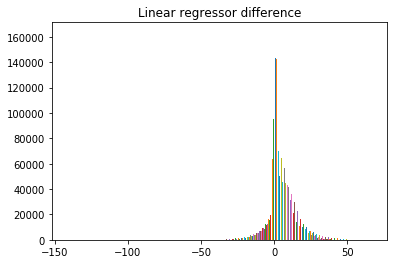

In [138]:
plt.hist(uif_diff, bins = 100)
plt.title("Linear regressor difference")
plt.show #some variance...

In [139]:
uif_out.reshape(-1,1).shape

(32213376, 1)

In [140]:
real_out = uif_out[10*36*72:11*36*72,10].reshape(36,72)
pred_out = uif_lin[10*36*72:11*36*72,10].reshape(36,72)

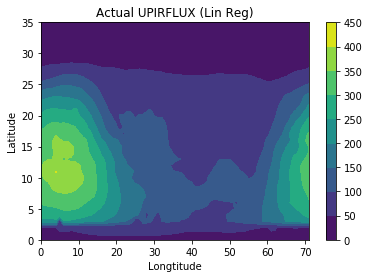

In [141]:
plt.contourf(real_out)
plt.colorbar()
plt.title("Actual UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

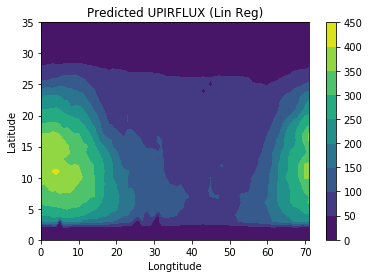

In [142]:
plt.contourf(pred_out)
plt.colorbar()
plt.title("Predicted UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

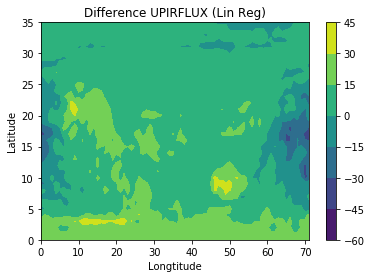

In [143]:
plt.contourf(real_out - pred_out)
plt.colorbar()
plt.title("Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

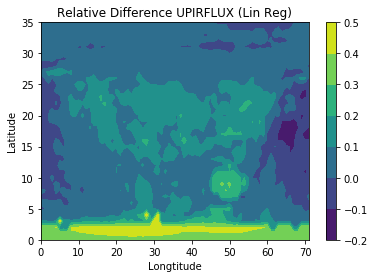

In [144]:
plt.contourf((real_out - pred_out)/real_out)
plt.colorbar()
plt.title("Relative Difference UPIRFLUX (Lin Reg)")
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.show()

## Getting the integrals of flux error (and then getting average erroneusly added flux)

In [145]:
def int_err(pred, real, real_in, r): 
    areas = []
    for i in range(len(real)):
        dA =  -r**2 * np.sin((np.pi/36)*((real_in.index[i]//72)%36)) * (np.pi/36) * (np.pi/36)  #area increment
        areas.append(dA)
    areas = np.array(areas)
    return np.sum((np.array(pred) - np.array(real))*areas)

In [146]:
real_out.shape

(36, 72)

In [147]:
lin_t_int = [] #total lin integral list, each element is one layer
for i in range(52): 
    lin_errors = [] #each element is one time snapshot
    for j in range(70):
        lin_int_err = int_err(uif_lin[j*36*72:(j+1)*36*72,i], uif_out[j*36*72:(j+1)*36*72,i], pd.DataFrame(uif_lin), 3.39e6) 
        lin_errors.append(lin_int_err/(1.44e14)) 
    lin_t_int.append(lin_errors)

In [148]:
lin_t_int = np.array(lin_t_int)
lin_t_int

array([[5.59260719, 5.52428257, 5.49681128, ..., 4.5860489 , 5.11574637,
        5.22664059],
       [5.59262191, 5.52428179, 5.49680609, ..., 4.58600885, 5.11568108,
        5.22660326],
       [5.59263197, 5.52427933, 5.496801  , ..., 4.58598054, 5.115634  ,
        5.22657707],
       ...,
       [8.14987443, 7.12912667, 7.56010224, ..., 6.37398719, 7.31004417,
        6.62178647],
       [8.03024679, 7.00113141, 7.43468656, ..., 6.29472576, 7.22103257,
        6.4897899 ],
       [7.88240018, 6.80675848, 7.30118265, ..., 6.1897716 , 7.09322111,
        6.29082506]])

In [149]:
max_err = []
for element in lin_t_int:
    max_err.append(np.max(element))
np.array(max_err)

array([5.80132345, 5.80132343, 5.80132278, 5.80125636, 5.80119054,
       5.80202804, 5.80346019, 5.80542427, 5.80752215, 5.80981234,
       5.811877  , 5.81340583, 5.81567899, 5.81978763, 5.8248771 ,
       5.83013767, 5.838494  , 5.85482111, 5.87947024, 5.90716364,
       5.93220824, 5.95594587, 5.98748892, 6.03793789, 6.10811467,
       6.19163796, 6.28895204, 6.40242921, 6.52481302, 6.64983171,
       6.78250536, 6.91771029, 7.06156269, 7.23286556, 7.43785776,
       7.68506567, 7.94896309, 8.1787403 , 8.30040115, 8.34929437,
       8.3895242 , 8.40664709, 8.41592307, 8.41444608, 8.40032682,
       8.38168369, 8.35142556, 8.30456393, 8.23754855, 8.14987443,
       8.03024679, 7.88240018])

In [150]:
min_err = []
for element in lin_t_int:
    min_err.append(np.min(element))
np.array(min_err)

array([4.55816928, 4.55815065, 4.55813769, 4.55805914, 4.55773042,
       4.55715731, 4.55646138, 4.55541936, 4.55514755, 4.55613951,
       4.55848608, 4.56277001, 4.57000663, 4.58116459, 4.59603363,
       4.6112997 , 4.62442248, 4.6362686 , 4.6469002 , 4.6583575 ,
       4.67285191, 4.69506147, 4.73517323, 4.79640781, 4.86960333,
       4.94782539, 5.03270519, 5.12963814, 5.23452348, 5.34520951,
       5.47103215, 5.60653099, 5.73327968, 5.85447791, 6.00908613,
       6.24073952, 6.50318817, 6.6718469 , 6.74468521, 6.74919427,
       6.73846653, 6.72313892, 6.69851617, 6.66330032, 6.61813406,
       6.58264364, 6.54379916, 6.49892545, 6.44240332, 6.35892645,
       6.23135185, 6.03934271])

In [151]:
std_err = []
for element in lin_t_int:
    std_err.append(np.std(element))
np.array(std_err)

array([0.30790784, 0.30791248, 0.30791534, 0.30790843, 0.30797865,
       0.30837722, 0.30901619, 0.30981294, 0.31038616, 0.31053024,
       0.31022052, 0.30938411, 0.30786553, 0.30578399, 0.30383887,
       0.30289248, 0.30319405, 0.30453076, 0.30681574, 0.30940051,
       0.31100902, 0.31084502, 0.30866652, 0.30628461, 0.30635161,
       0.30950817, 0.31456098, 0.31931471, 0.32329524, 0.32681216,
       0.32903129, 0.32987876, 0.33576462, 0.35137229, 0.36672417,
       0.36971655, 0.36973317, 0.38233047, 0.40307755, 0.41408252,
       0.42802459, 0.4381561 , 0.44952729, 0.46126973, 0.47214713,
       0.47854928, 0.483272  , 0.48581157, 0.48750079, 0.4894239 ,
       0.49112463, 0.49897153])

In [152]:
avg_err = []
for element in lin_t_int:
    avg_err.append(np.average(element))
np.array(avg_err)

array([5.26218527, 5.26217057, 5.26215939, 5.26203212, 5.26184532,
       5.26193381, 5.26240347, 5.26323109, 5.26436231, 5.26584221,
       5.2677206 , 5.27053604, 5.27511522, 5.28207826, 5.29152502,
       5.30302488, 5.31600072, 5.33064692, 5.34640609, 5.36393308,
       5.38424239, 5.4094023 , 5.44478738, 5.49664679, 5.56460263,
       5.64686624, 5.74432595, 5.85613719, 5.97450374, 6.095285  ,
       6.22617043, 6.36425346, 6.50715756, 6.66523006, 6.84935639,
       7.07154583, 7.29797476, 7.48108616, 7.57298529, 7.58441223,
       7.58007428, 7.56846021, 7.54836704, 7.51865252, 7.47865065,
       7.44484769, 7.40357146, 7.35196166, 7.2854025 , 7.20066765,
       7.08826515, 6.94114079])

In [153]:
print("Lin reg average:")
print(np.average(np.array(lin_t_int)))

Lin reg average:
6.160042033317421
